In [2]:
from sqlalchemy.orm import Session
from db import Researcher, Paper, Authorship, Citation, engine
session = Session(engine)

Database already exists


In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy.orm import aliased
import requests
import backoff

fail_count = 0
@backoff.on_exception(backoff.expo, requests.exceptions.RequestException, max_tries=8)
def post_url(url, params, json, pbar):
    global fail_count
    r = requests.post(url, params=params, json=json)

    if r.status_code != 200:
        fail_count +=1
        pbar.set_description(f"Failed {fail_count} times")
        raise requests.exceptions.RequestException

    return r

In [20]:
def get_numbers_by_author(author_ss_id):
    author_papers = session.query(Paper.semantic_scholar_id).join(Authorship).join(Researcher).filter(Researcher.semantic_scholar_id == author_ss_id).subquery()
    result = session.query(Citation).join(author_papers, Citation.citing_paper_id == author_papers.c.semantic_scholar_id).all()

    h_index = session.query(Researcher.h_index).filter(Researcher.semantic_scholar_id == author_ss_id).first()[0]
    paper_count = len(session.query(author_papers).all())

    positive = 0
    negative = 0
    neutral = 0
    bad_context = 0

    for row in result:
        if row.llm_purpose == 'POSITIVE':
            positive += 1
        elif row.llm_purpose == 'NEGATIVE':
            negative += 1
        elif row.llm_purpose == 'NEUTRAL':
            neutral += 1
        else:
            bad_context += 1

    return {"h_index": h_index, "paper_count":paper_count, "positive":positive, "negative":negative, "neutral":neutral, "bad_context":bad_context}


In [21]:
author_numbers = []
with open("./../profs1.csv") as f:
    for line in tqdm(f):
        name, ss_id = line.split(",")
        numbers = get_numbers_by_author(int(ss_id.strip()))
        numbers["name"] = name
        author_numbers.append(numbers)

author_numbers

96it [00:44,  2.17it/s]


[{'h_index': 16,
  'paper_count': 34,
  'positive': 214,
  'negative': 225,
  'neutral': 1046,
  'bad_context': 52,
  'name': 'Yousra Aafer'},
 {'h_index': 16,
  'paper_count': 64,
  'positive': 427,
  'negative': 265,
  'neutral': 1820,
  'bad_context': 95,
  'name': 'Samer Al-Kiswany'},
 {'h_index': 5,
  'paper_count': 7,
  'positive': 48,
  'negative': 39,
  'neutral': 183,
  'bad_context': 12,
  'name': 'N. Asokan'},
 {'h_index': 23,
  'paper_count': 99,
  'positive': 1170,
  'negative': 342,
  'neutral': 3229,
  'bad_context': 206,
  'name': 'Sepehr Assadi'},
 {'h_index': 23,
  'paper_count': 109,
  'positive': 566,
  'negative': 283,
  'neutral': 2109,
  'bad_context': 171,
  'name': 'Joanne Atlee'},
 {'h_index': 22,
  'paper_count': 152,
  'positive': 1187,
  'negative': 481,
  'neutral': 4473,
  'bad_context': 268,
  'name': 'Gladimir Baranoski'},
 {'h_index': 7,
  'paper_count': 27,
  'positive': 383,
  'negative': 306,
  'neutral': 994,
  'bad_context': 34,
  'name': 'Diogo B

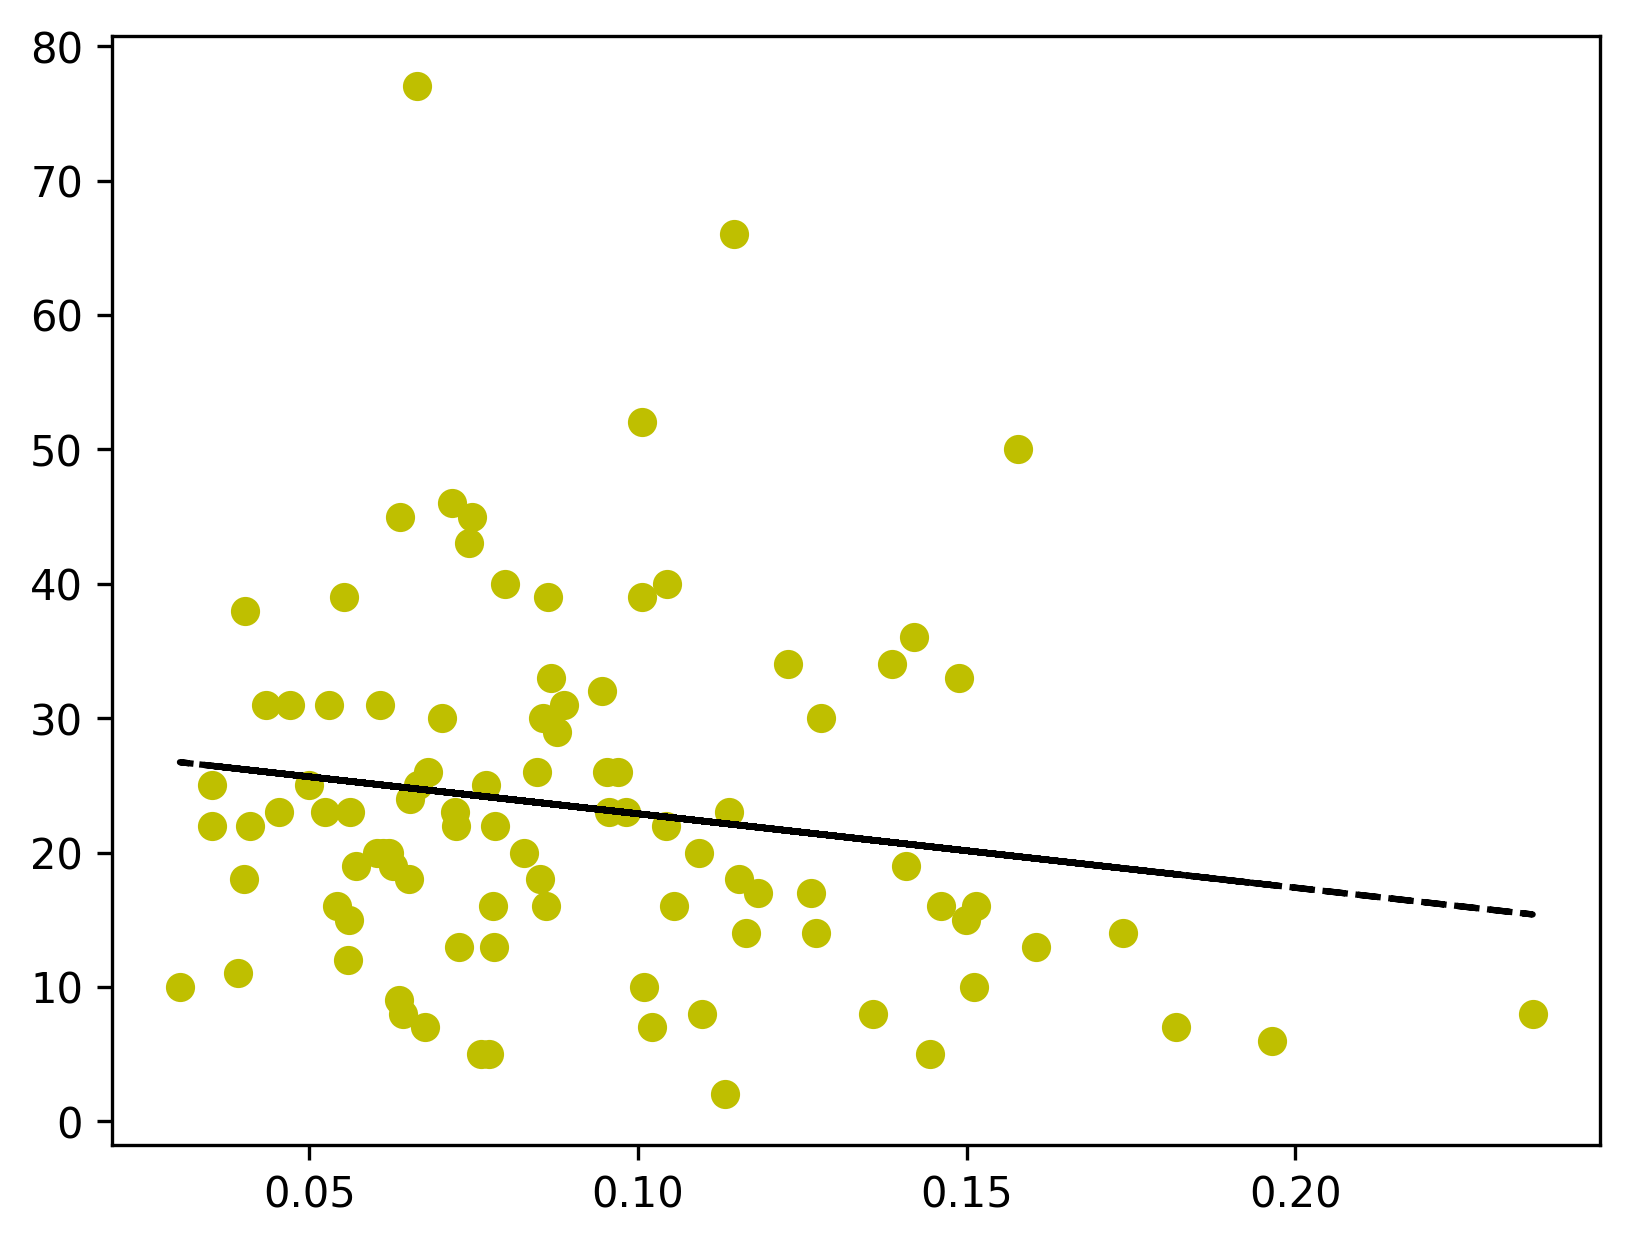

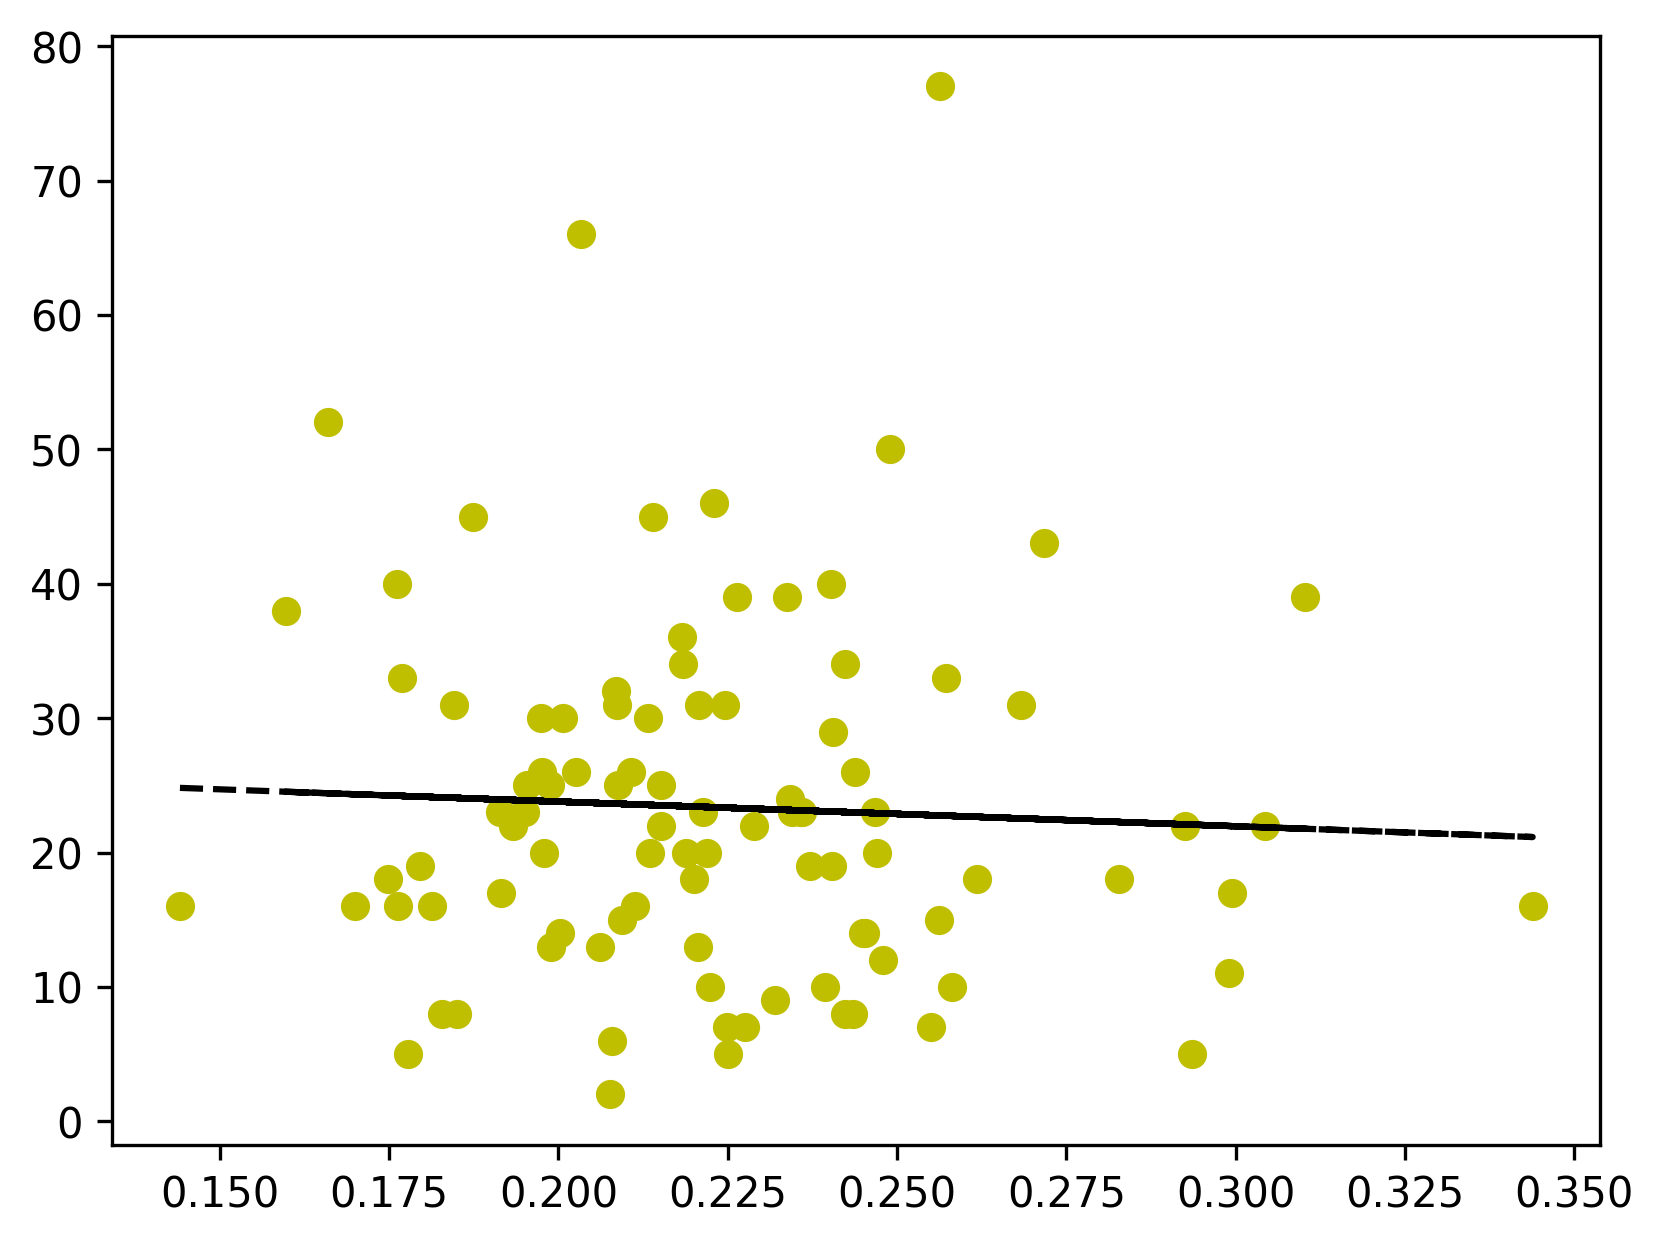

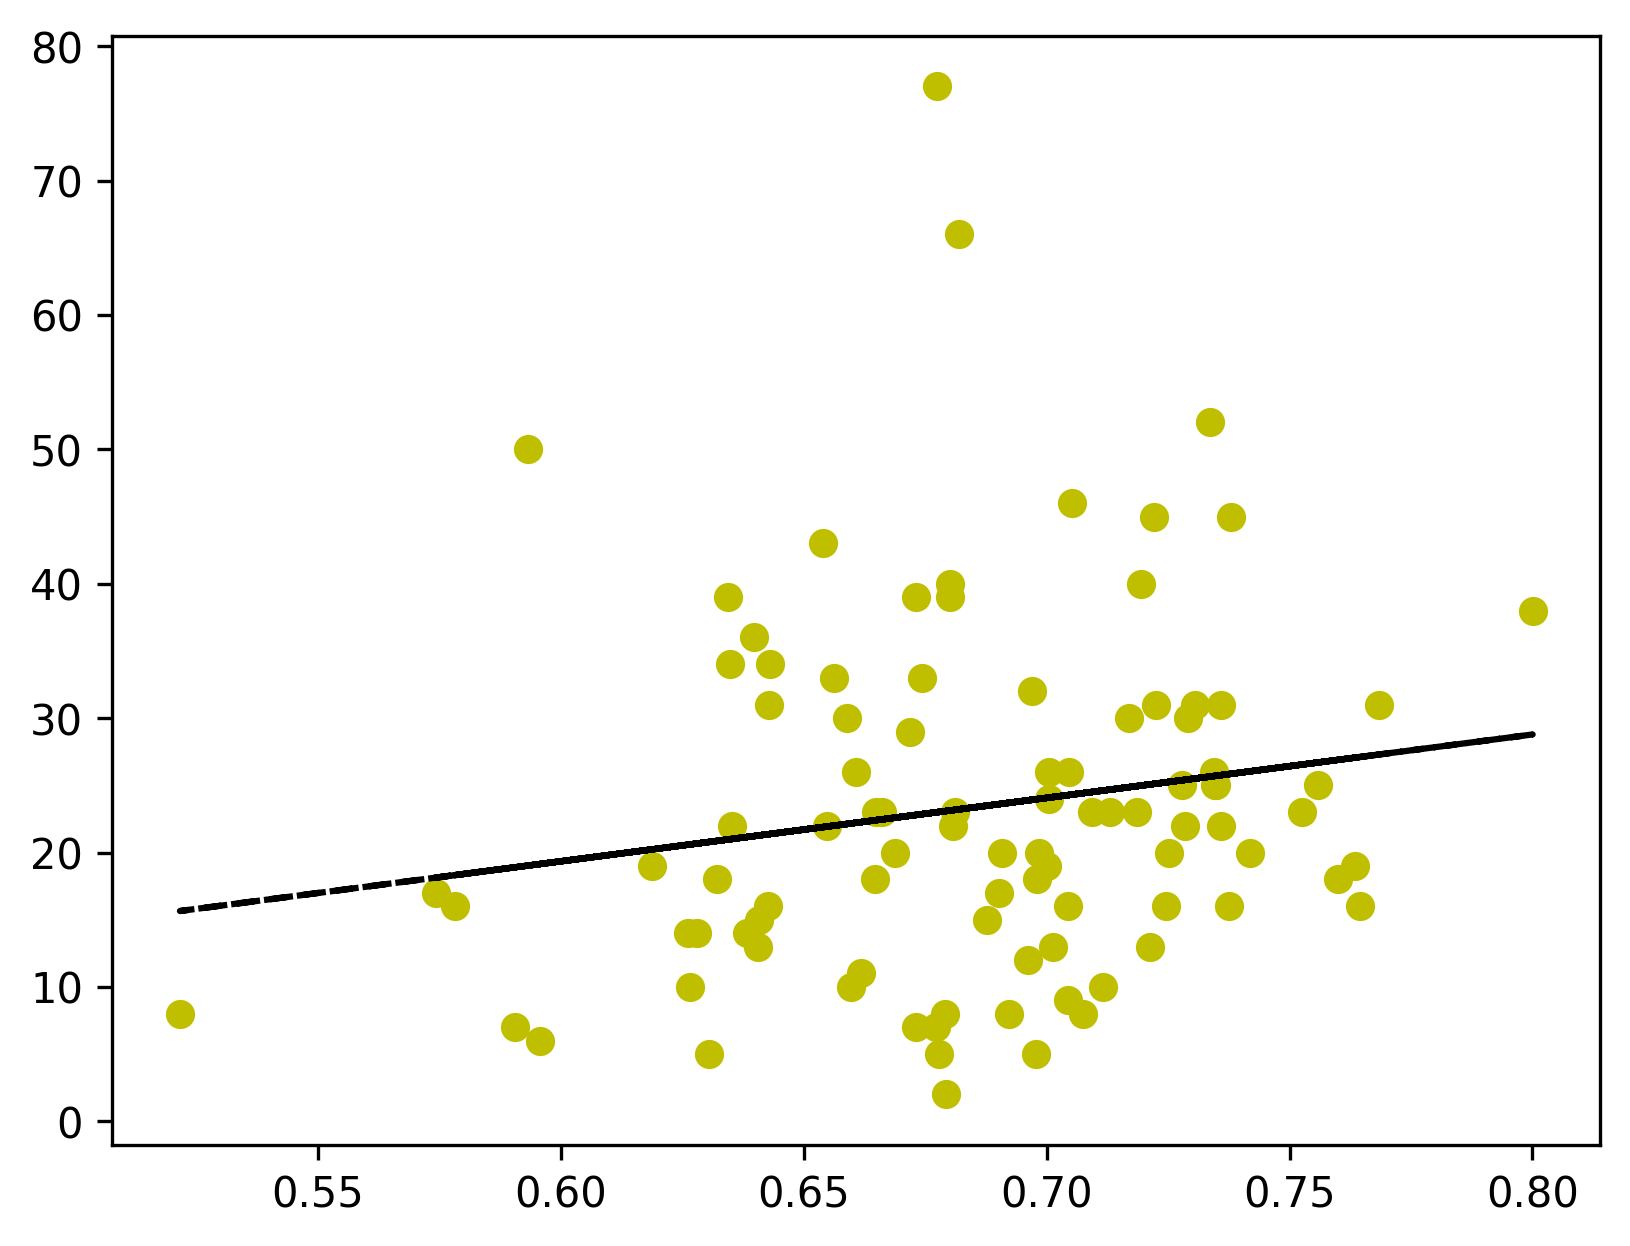

In [74]:

y = [x["h_index"] for x in author_numbers]
x = [x["negative"]/(x["neutral"]+x["positive"]+x["negative"]) for x in author_numbers]

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)

plt.plot(x, y, 'yo', x, poly1d_fn(x), '--k')
plt.show()

x = [x["positive"]/(x["neutral"]+x["positive"]+x["negative"]) for x in author_numbers]
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)

plt.plot(x, y, 'yo', x, poly1d_fn(x), '--k')
plt.show()

x = [x["neutral"]/(x["neutral"]+x["positive"]+x["negative"]) for x in author_numbers]
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)

plt.plot(x, y, 'yo', x, poly1d_fn(x), '--k')
plt.show()

In [43]:
poly1d_fn(0.10)

22.8848640738316

In [61]:
y = [x["h_index"] for x in author_numbers]
x = [x["neutral"]/(x["neutral"]+x["positive"]+x["negative"]) for x in author_numbers]

xy = [f'({round(x*100, 2)},{y})' for x,y in zip(x,y)]
xy = "".join(xy)
print(xy)

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)


(70.44,16)(72.45,16)(67.78,5)(68.11,23)(71.3,23)(72.84,22)(59.06,7)(63.2,18)(73.47,25)(66.18,11)(69.69,32)(73.44,26)(69.81,18)(68.2,66)(68.0,40)(69.77,5)(66.48,23)(62.79,14)(64.06,13)(70.05,24)(70.53,46)(63.44,39)(64.29,31)(67.3,39)(69.02,17)(76.45,16)(69.85,20)(69.62,12)(71.86,23)(71.93,40)(59.32,50)(61.88,19)(57.42,17)(63.52,22)(65.97,10)(70.43,9)(64.07,15)(67.43,33)(65.4,43)(67.73,7)(73.79,45)(70.47,26)(70.92,23)(76.83,31)(64.27,16)(63.97,36)(72.25,31)(66.61,23)(65.47,22)(57.82,16)(72.92,30)(68.0,39)(70.04,26)(63.82,14)(67.74,77)(67.91,8)(69.23,8)(73.59,22)(67.3,7)(72.12,13)(72.78,25)(62.61,14)(64.3,34)(63.49,34)(70.75,8)(75.25,23)(68.77,15)(69.08,20)(73.35,52)(72.22,45)(72.52,20)(66.46,18)(73.06,31)(75.99,18)(73.59,31)(80.0,38)(71.16,10)(63.04,5)(75.59,25)(68.07,22)(62.65,10)(71.69,30)(73.76,16)(65.61,33)(65.89,30)(70.13,13)(73.49,25)(74.18,20)(66.88,20)(67.92,2)(67.19,29)(52.16,8)(66.08,26)(59.57,6)(70.01,19)(76.34,19)


In [62]:
mean = [f'({round(x*100, 2)},{round(poly1d_fn(x),2)})' for x in np.linspace(0.50,0.80,9)]
mean = "".join(mean)
print(mean)

(50.0,14.63)(53.75,16.4)(57.5,18.17)(61.25,19.94)(65.0,21.71)(68.75,23.48)(72.5,25.24)(76.25,27.01)(80.0,28.78)


In [7]:
waterloo_profs = session.query(Researcher).filter(Researcher.waterloo_prof == 1).subquery()
waterloo_papers = session.query(Paper.semantic_scholar_id, Paper.citation_count, Paper.year, waterloo_profs.c.id).select_from(Paper).join(Authorship).join(waterloo_profs, Authorship.researcher_id == waterloo_profs.c.id).all()
# papers = session.query(Paper.semantic_scholar_id, Paper.citation_count, Paper.year).all()

data_list = []

for paper in tqdm(waterloo_papers):
    citations = session.query(Citation).filter(Citation.citing_paper_id == paper[0]).all()
    positive = 0
    negative = 0
    neutral = 0
    bad_context = 0
    for citation in citations:
        if citation.llm_purpose == 'POSITIVE':
            positive += 1
        elif citation.llm_purpose == 'NEGATIVE':
            negative += 1
        elif citation.llm_purpose == 'NEUTRAL':
            neutral += 1
        else:
            bad_context += 1
    data_list.append({"researcher_id": paper[3], "year": paper[2], "paper_id": paper[0], "citation_count":paper[1], "positive":positive, "negative":negative, "neutral":neutral, "bad_context":bad_context})

100%|██████████| 10076/10076 [19:26<00:00,  8.64it/s]


In [9]:
data_list[0]

{'researcher_id': 1,
 'year': 2023,
 'paper_id': '1263a9ca6627b91b1ef84d304c2df594a0621f68',
 'citation_count': 3,
 'positive': 17,
 'negative': 18,
 'neutral': 74,
 'bad_context': 2}

In [11]:
waterloo_prof_ids = [x[0] for x in session.query(waterloo_profs.c.id).all()]
citation_counts = {}

for i in tqdm(range(850)):
    for prof in waterloo_prof_ids:
        profs_papers = [x for x in data_list if x["researcher_id"] == prof and x["year"] is not None]
        profs_papers = sorted(profs_papers, key=lambda x: (x["year"],x["paper_id"]))
        if len(profs_papers) > i:
            ith_citation_counts = citation_counts.setdefault(i, {"positive": 0 , "negative": 0, "neutral": 0, "bad_context": 0, "paper_count": 0})
            ith_citation_counts["positive"] += profs_papers[i]["positive"]
            ith_citation_counts["negative"] += profs_papers[i]["negative"]
            ith_citation_counts["neutral"] += profs_papers[i]["neutral"]
            ith_citation_counts["bad_context"] += profs_papers[i]["bad_context"]
            ith_citation_counts["paper_count"] += 1

citation_counts

100%|██████████| 850/850 [00:29<00:00, 28.74it/s]


{0: {'positive': 449,
  'negative': 152,
  'neutral': 1542,
  'bad_context': 123,
  'paper_count': 96},
 1: {'positive': 335,
  'negative': 184,
  'neutral': 1148,
  'bad_context': 71,
  'paper_count': 96},
 2: {'positive': 509,
  'negative': 193,
  'neutral': 1560,
  'bad_context': 96,
  'paper_count': 96},
 3: {'positive': 447,
  'negative': 231,
  'neutral': 1538,
  'bad_context': 78,
  'paper_count': 96},
 4: {'positive': 524,
  'negative': 253,
  'neutral': 1767,
  'bad_context': 120,
  'paper_count': 96},
 5: {'positive': 573,
  'negative': 219,
  'neutral': 1622,
  'bad_context': 90,
  'paper_count': 96},
 6: {'positive': 635,
  'negative': 218,
  'neutral': 1816,
  'bad_context': 107,
  'paper_count': 95},
 7: {'positive': 694,
  'negative': 292,
  'neutral': 2043,
  'bad_context': 150,
  'paper_count': 94},
 8: {'positive': 788,
  'negative': 318,
  'neutral': 2494,
  'bad_context': 107,
  'paper_count': 93},
 9: {'positive': 592,
  'negative': 256,
  'neutral': 1651,
  'bad_c

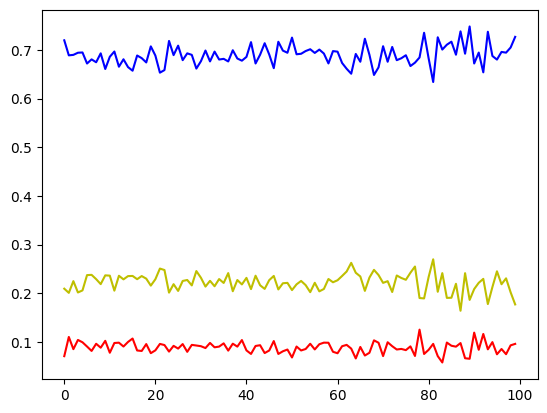

In [12]:
x = [x for x in range(100)]
y_pos = [citation_counts[x]["positive"]/(citation_counts[x]["positive"]+citation_counts[x]["negative"]+citation_counts[x]["neutral"]) for x in range(100)]
y_neg = [citation_counts[x]["negative"]/(citation_counts[x]["positive"]+citation_counts[x]["negative"]+citation_counts[x]["neutral"]) for x in range(100)]
y_neu = [citation_counts[x]["neutral"]/(citation_counts[x]["positive"]+citation_counts[x]["negative"]+citation_counts[x]["neutral"]) for x in range(100)]

plt.plot(x, y_pos, 'y', x, y_neg, 'r', x, y_neu, 'b')

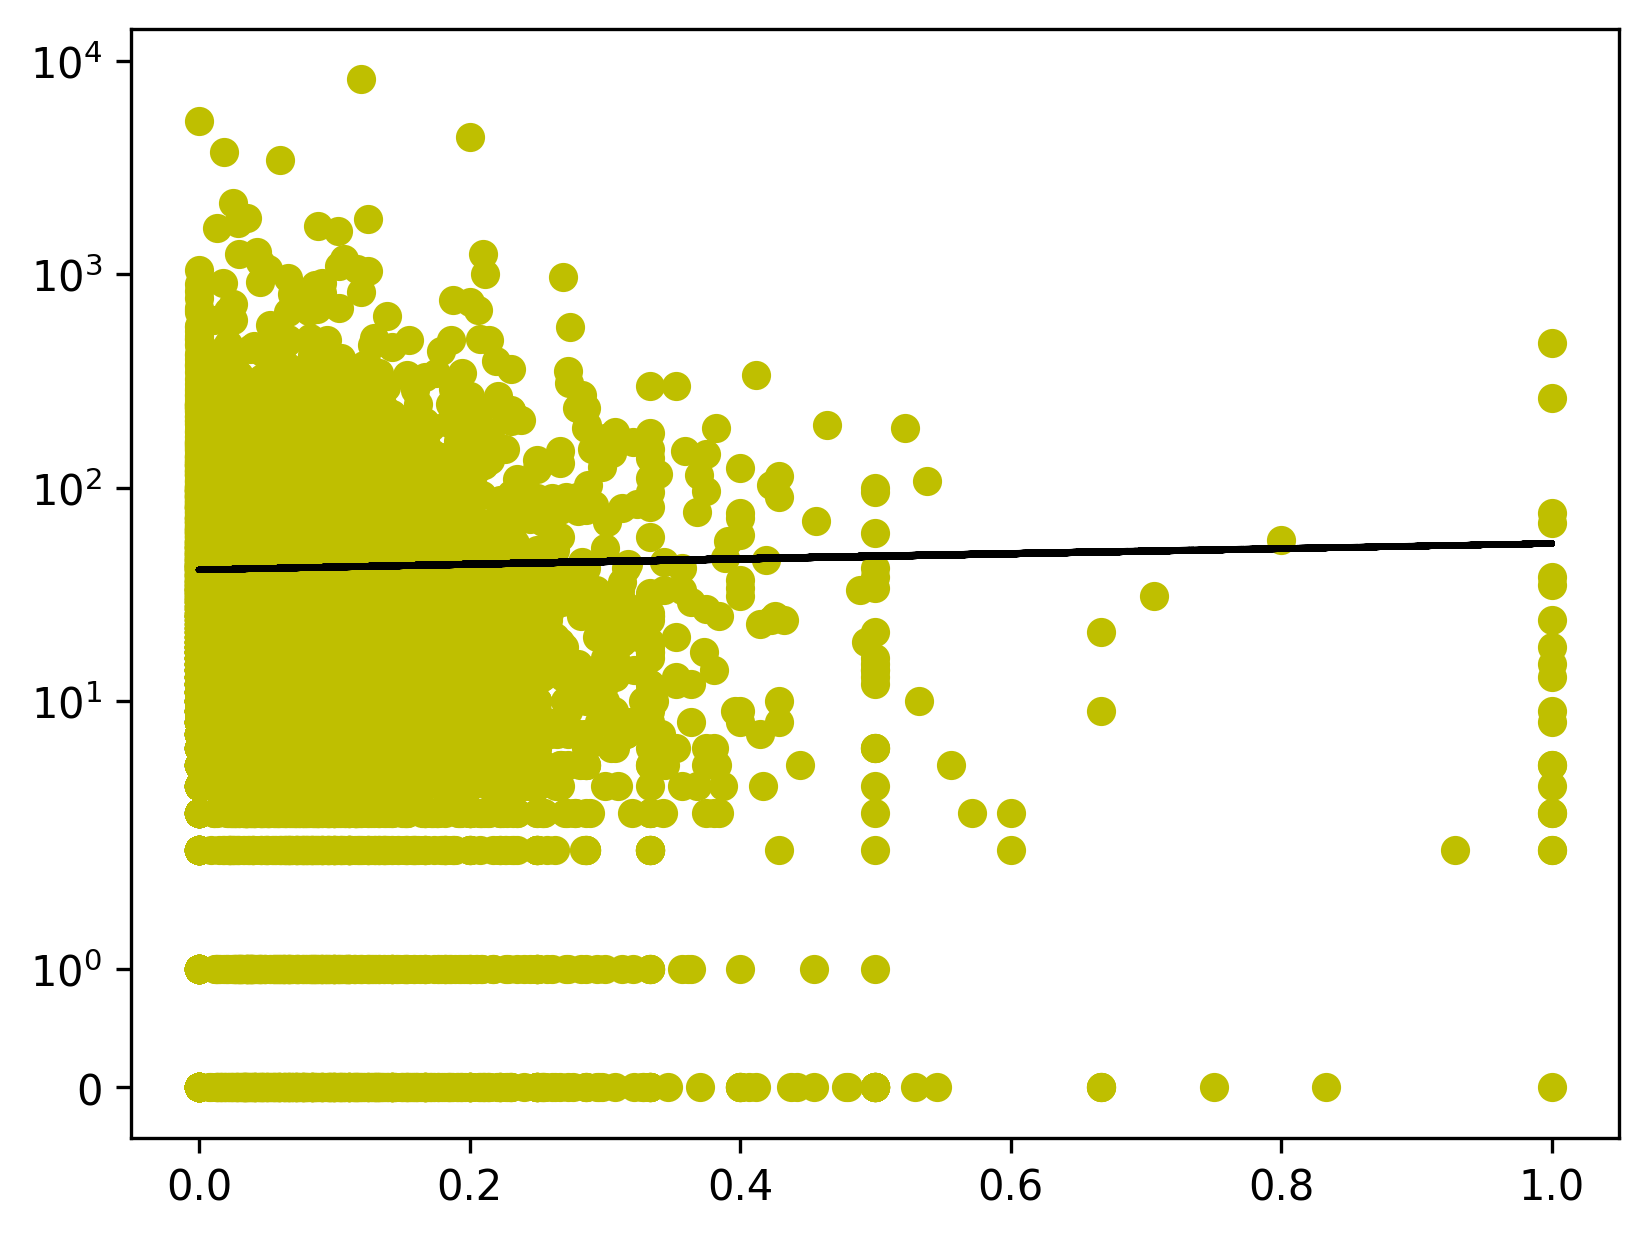

In [95]:
y = [x["citation_count"] for x in data_list if x["neutral"]+x["positive"]+x["negative"] > 0]
x = [x["negative"]/(x["neutral"]+x["positive"]+x["negative"]) for x in data_list if x["neutral"]+x["positive"]+x["negative"] > 0]

plt.yscale("symlog")
coef = np.polyfit(x,y,1)
# poly1d_fn = np.polyval(coef)

plt.plot(x, y, 'yo', x, np.polyval(coef,x), '--k')
plt.show()


In [3]:
author_numbers = []
with open("./../profs1.csv") as f:
    for line in tqdm(f):
        name, ss_id = line.split(",")
        ss_id = int(ss_id.strip())
        session.query(Researcher).filter(Researcher.semantic_scholar_id == ss_id).update({"waterloo_prof":1})
        session.commit()

96it [00:00, 1050.62it/s]


In [13]:
Paper1 = aliased(Paper, name="p1")
Paper2 = aliased(Paper, name="p2")
res = session.query(Citation).join(Paper1, Citation.citing_paper_id == Paper1.semantic_scholar_id).join(Paper2, Citation.cited_paper_id == Paper2.semantic_scholar_id).all()
print(len(res))

positive = 0
negative = 0
neutral = 0
bad_context = 0

for row in res:
    if row.llm_purpose == 'POSITIVE':
        positive += 1
    elif row.llm_purpose == 'NEGATIVE':
        negative += 1
    elif row.llm_purpose == 'NEUTRAL':
        neutral += 1
    else:
        bad_context += 1

print(positive, negative, neutral, bad_context)
total = positive + negative + neutral
print(positive/total, negative/total, neutral/total)

31267
7530 2243 20232 1262
0.25095817363772704 0.07475420763206132 0.6742876187302116


In [14]:
Paper1 = aliased(Paper, name="p1")
Paper2 = aliased(Paper, name="p2")
res_sub = session.query(Citation).join(Paper1, Citation.citing_paper_id == Paper1.semantic_scholar_id).join(Paper2, Citation.cited_paper_id == Paper2.semantic_scholar_id)
res = session.query(Citation).except_(res_sub).all()
print(len(res))

positive = 0
negative = 0
neutral = 0
bad_context = 0

for row in res:
    if row.llm_purpose == 'POSITIVE':
        positive += 1
    elif row.llm_purpose == 'NEGATIVE':
        negative += 1
    elif row.llm_purpose == 'NEUTRAL':
        neutral += 1
    else:
        bad_context += 1

print(positive, negative, neutral, bad_context)
total = positive + negative + neutral
print(positive/total, negative/total, neutral/total)

666342
143109 56811 437231 29191
0.2246076675701678 0.08916410709549227 0.6862282253343399


In [19]:
#get the number of papers per waterloo prof
from sqlalchemy import func
q1 = session.query(Researcher).filter(Researcher.waterloo_prof == 1).subquery()
res = session.query(func.count(Authorship.id), q1.c.name, q1.c.id).join(q1, Authorship.researcher_id == q1.c.id).group_by(q1.c.name).all()

res = sorted(res, key=lambda x: x[0])
res

[(6, 'Meng Xu', 10699),
 (7, 'N. Asokan', 177),
 (8, 'Timothy B. Brecht', 2282),
 (14, 'Shlomi Steinberg', 9672),
 (16, 'Freda Shi', 9631),
 (17, 'Hong Zhang', 10809),
 (17, 'Yizhou Zhang', 10972),
 (18, 'Mina Tahmasbi Arashloo', 2146),
 (19, 'Sujaya Maiyya', 5942),
 (21, 'Jason S. Hartford', 4734),
 (22, 'Xiao Hu', 5192),
 (22, 'Yang Young Lu', 7470),
 (24, 'Pengyu Nie', 8139),
 (27, 'A. Mashtizadeh', 145),
 (27, 'Diogo Barradas', 575),
 (29, 'R. Oliveira', 8221),
 (30, 'Mohammad Hajiabadi', 4688),
 (34, 'Yousra Aafer', 1),
 (35, 'Sihang Liu', 7390),
 (36, 'Trevor Brown', 2788),
 (38, 'Yuntian Deng', 3892),
 (40, 'K. Fountoulakis', 3987),
 (40, 'Xi He', 4774),
 (41, 'R. Mann', 3351),
 (41, 'S. Gorbunov', 1583),
 (42, 'Jian Zhao', 9318),
 (42, 'Victor Zhong', 11074),
 (44, 'Noura Limam', 604),
 (46, 'Richard J. Trefler', 10222),
 (47, 'E. Law', 3037),
 (49, 'Chengnian Sun', 4351),
 (50, 'Gautam Kamath', 5426),
 (50, 'Maura R. Grossman', 3129),
 (53, 'J. Wan', 511),
 (54, 'Christopher B

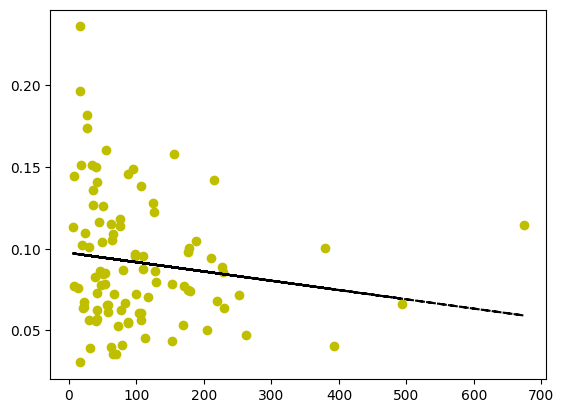

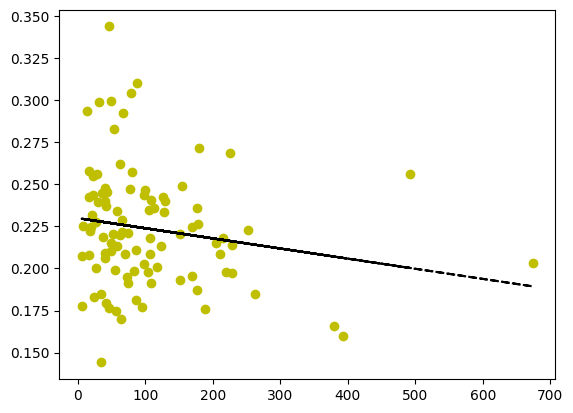

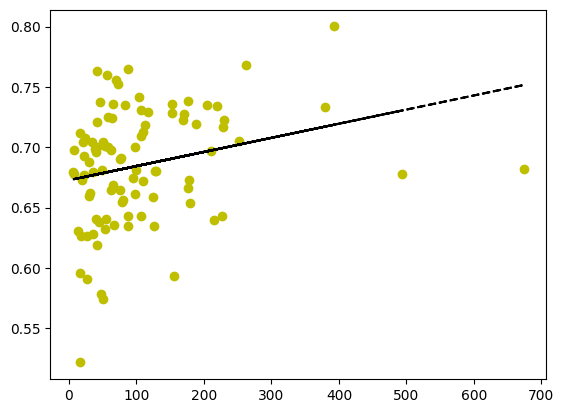

In [24]:
x = [x["paper_count"] for x in author_numbers]
y = [x["negative"]/(x["neutral"]+x["positive"]+x["negative"]) for x in author_numbers]

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)

plt.plot(x, y, 'yo', x, poly1d_fn(x), '--k')
plt.show()

x = [x["paper_count"] for x in author_numbers]
y = [x["positive"]/(x["neutral"]+x["positive"]+x["negative"]) for x in author_numbers]

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)

plt.plot(x, y, 'yo', x, poly1d_fn(x), '--k')
plt.show()

x = [x["paper_count"] for x in author_numbers]
y = [x["neutral"]/(x["neutral"]+x["positive"]+x["negative"]) for x in author_numbers]

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)

plt.plot(x, y, 'yo', x, poly1d_fn(x), '--k')
plt.show()

In [32]:
x = [x["paper_count"] for x in author_numbers]
y = [x["neutral"]/(x["neutral"]+x["positive"]+x["negative"]) for x in author_numbers]

xy = [f'({x},{round(y*100, 2)})' for x,y in zip(x,y)]
xy = "".join(xy)
print(xy)

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)

(34,70.44)(64,72.45)(7,67.78)(99,68.11)(109,71.3)(152,72.84)(27,59.06)(54,63.2)(83,73.47)(31,66.18)(211,69.69)(219,73.44)(62,69.81)(674,68.2)(129,68.0)(8,69.77)(75,66.48)(36,62.79)(55,64.06)(58,70.05)(252,70.53)(88,63.44)(226,64.29)(178,67.3)(75,69.02)(87,76.45)(38,69.85)(40,69.62)(113,71.86)(188,71.93)(155,59.32)(41,61.88)(50,57.42)(67,63.52)(30,65.97)(21,70.43)(40,64.07)(95,67.43)(179,65.4)(22,67.73)(176,73.79)(50,70.47)(106,70.92)(262,76.83)(87,64.27)(215,63.97)(169,72.25)(177,66.61)(79,65.47)(47,57.82)(117,72.92)(128,68.0)(98,70.04)(44,63.82)(493,67.74)(35,67.91)(22,69.23)(65,73.59)(19,67.3)(41,72.12)(170,72.78)(27,62.61)(107,64.3)(126,63.49)(24,70.75)(73,75.25)(29,68.77)(77,69.08)(380,73.35)(229,72.22)(58,72.52)(63,66.46)(107,73.06)(56,75.99)(152,73.59)(393,80.0)(16,71.16)(14,63.04)(70,75.59)(49,68.07)(18,62.65)(228,71.69)(46,73.76)(80,65.61)(124,65.89)(53,70.13)(205,73.49)(104,74.18)(65,66.88)(6,67.92)(109,67.19)(17,52.16)(98,66.08)(17,59.57)(42,70.01)(42,76.34)


In [33]:
mean = [f'({x},{round(poly1d_fn(x)*100,2)})' for x in np.linspace(0,690,9)]
mean = "".join(mean)
print(mean)

(0.0,67.26)(86.25,68.27)(172.5,69.28)(258.75,70.29)(345.0,71.3)(431.25,72.31)(517.5,73.32)(603.75,74.33)(690.0,75.34)


In [46]:
batch_size = 400
paper_details = []
pbar = tqdm(range(0, 697609, batch_size))
fail_count = 0
for i in pbar:
    citations = session.query(Citation).offset(i).limit(batch_size).all()
    paper_ids = [citation.citing_paper_id for citation in citations]
    r = post_url("https://api.semanticscholar.org/graph/v1/paper/batch", params={"fields": "year"}, json={"ids": paper_ids}, pbar=pbar).json()
    
    res = [[citation.id, paper["year"] if paper != None else 'NONE', citation.llm_purpose] for citation, paper in zip(citations, r)]
    
    with open("Citation_years.csv", "a") as f:
        for row in res:
            f.write(f"{row[0]},{row[1]},{row[2]}\n")
        


Failed 289 times: 100%|██████████| 1745/1745 [29:37<00:00,  1.02s/it]


In [48]:
citation_years = {}
with open("Citation_years.csv", "r") as f:
    rows = f.readlines()
    for row in tqdm(rows):
        row = row.split(",")
        if row[1].strip() == "NONE" or row[1].strip() == "None":
            continue
        year = int(row[1].strip())
        if year in citation_years:
            citation_years[year][row[2].strip()] += 1
        else:
            citation_years[year] = {"POSITIVE":0, "NEGATIVE":0, "NEUTRAL":0, "BAD_CONTEXT":0}
            citation_years[year][row[2].strip()] += 1
    
citation_years

100%|██████████| 697609/697609 [00:00<00:00, 1262499.05it/s]


{2023: {'POSITIVE': 10177,
  'NEGATIVE': 4332,
  'NEUTRAL': 28947,
  'BAD_CONTEXT': 1609},
 2022: {'POSITIVE': 12592,
  'NEGATIVE': 4843,
  'NEUTRAL': 35490,
  'BAD_CONTEXT': 2006},
 2021: {'POSITIVE': 12277,
  'NEGATIVE': 5034,
  'NEUTRAL': 36357,
  'BAD_CONTEXT': 1976},
 2020: {'POSITIVE': 13478,
  'NEGATIVE': 5501,
  'NEUTRAL': 39432,
  'BAD_CONTEXT': 2341},
 2019: {'POSITIVE': 11347,
  'NEGATIVE': 4488,
  'NEUTRAL': 34562,
  'BAD_CONTEXT': 2109},
 2024: {'POSITIVE': 76, 'NEGATIVE': 45, 'NEUTRAL': 158, 'BAD_CONTEXT': 5},
 2018: {'POSITIVE': 10563,
  'NEGATIVE': 3993,
  'NEUTRAL': 31390,
  'BAD_CONTEXT': 1724},
 2017: {'POSITIVE': 9878,
  'NEGATIVE': 3824,
  'NEUTRAL': 29390,
  'BAD_CONTEXT': 1722},
 2016: {'POSITIVE': 8372,
  'NEGATIVE': 3559,
  'NEUTRAL': 24997,
  'BAD_CONTEXT': 1890},
 2015: {'POSITIVE': 7605,
  'NEGATIVE': 3105,
  'NEUTRAL': 24170,
  'BAD_CONTEXT': 1977},
 2014: {'POSITIVE': 6540,
  'NEGATIVE': 2607,
  'NEUTRAL': 20404,
  'BAD_CONTEXT': 1470},
 2013: {'POSITIVE':

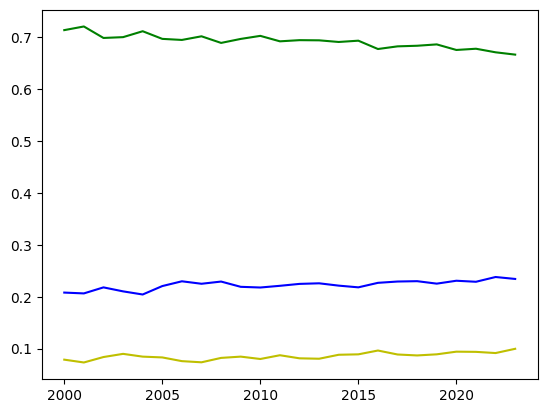

In [59]:
x = [i for i in range(2000,2024)]
y_negative = [citation_years[year]["NEGATIVE"]/(citation_years[year]["POSITIVE"]+citation_years[year]["NEGATIVE"]+citation_years[year]["NEUTRAL"])  for year in x]
y_positive = [citation_years[year]["POSITIVE"]/(citation_years[year]["POSITIVE"]+citation_years[year]["NEGATIVE"]+citation_years[year]["NEUTRAL"])  for year in x]
y_neutral = [citation_years[year]["NEUTRAL"]/(citation_years[year]["POSITIVE"]+citation_years[year]["NEGATIVE"]+citation_years[year]["NEUTRAL"])  for year in x]

plt.plot(x, y_negative, 'y', x, y_positive, 'b', x, y_neutral, 'g')

plt.show()


In [60]:
neg_coords = [f'({x},{round(y*100, 2)})' for x,y in zip(x,y_negative)]
neg_coords = "".join(neg_coords)
print(neg_coords)

(2000,7.88)(2001,7.34)(2002,8.38)(2003,9.0)(2004,8.46)(2005,8.31)(2006,7.59)(2007,7.37)(2008,8.22)(2009,8.46)(2010,8.01)(2011,8.73)(2012,8.14)(2013,8.06)(2014,8.82)(2015,8.9)(2016,9.64)(2017,8.87)(2018,8.69)(2019,8.91)(2020,9.42)(2021,9.38)(2022,9.15)(2023,9.97)


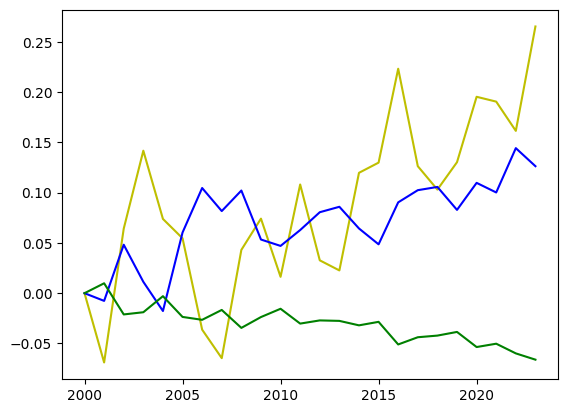

In [65]:
y_neg_change = [(i/y_negative[0])-1 for i in y_negative]
y_pos_change = [(i/y_positive[0])-1 for i in y_positive]
y_neu_change = [(i/y_neutral[0])-1 for i in y_neutral]

plt.plot(x, y_neg_change, 'y', x, y_pos_change, 'b', x, y_neu_change, 'g')

plt.show()

In [66]:
neg_coords = [f'({x},{round(y*100, 2)})' for x,y in zip(x,y_neg_change)]
neg_coords = "".join(neg_coords)
print(neg_coords)

(2000,0.0)(2001,-6.89)(2002,6.41)(2003,14.17)(2004,7.38)(2005,5.46)(2006,-3.63)(2007,-6.46)(2008,4.31)(2009,7.41)(2010,1.63)(2011,10.81)(2012,3.27)(2013,2.26)(2014,11.97)(2015,12.98)(2016,22.32)(2017,12.63)(2018,10.3)(2019,13.03)(2020,19.53)(2021,19.05)(2022,16.14)(2023,26.52)


In [67]:
pos_coords = [f'({x},{round(y*100, 2)})' for x,y in zip(x,y_pos_change)]
pos_coords = "".join(pos_coords)
print(pos_coords)

(2000,0.0)(2001,-0.77)(2002,4.82)(2003,1.13)(2004,-1.77)(2005,6.03)(2006,10.46)(2007,8.17)(2008,10.21)(2009,5.34)(2010,4.7)(2011,6.28)(2012,8.05)(2013,8.59)(2014,6.44)(2015,4.86)(2016,9.03)(2017,10.24)(2018,10.57)(2019,8.28)(2020,10.97)(2021,10.02)(2022,14.42)(2023,12.63)


In [68]:
neu_coords = [f'({x},{round(y*100, 2)})' for x,y in zip(x,y_neu_change)]
neu_coords = "".join(neu_coords)
print(neu_coords)

(2000,0.0)(2001,0.98)(2002,-2.11)(2003,-1.89)(2004,-0.3)(2005,-2.36)(2006,-2.65)(2007,-1.67)(2008,-3.45)(2009,-2.37)(2010,-1.55)(2011,-3.02)(2012,-2.71)(2013,-2.75)(2014,-3.2)(2015,-2.85)(2016,-5.1)(2017,-4.38)(2018,-4.22)(2019,-3.85)(2020,-5.36)(2021,-5.02)(2022,-5.99)(2023,-6.61)
